# 基因在不同社会阶级中的保留率

先做出以下假设：

我们将社会分成若干等级，以下主要分为三个层次：

1. 富人：具有较高的生存能力（可通过经济等手段抵抗生存压力）。
2. 中等阶级：具有一定的生存能力。
3. 穷人：具有较差的生存能力。

## 初始人口情况

我们假设初始时人口的分配主要以中等阶级为大多数，占比0.8；富人、穷人为少数，均占0.1。

In [86]:
import matplotlib.pyplot as plt
import numpy as np

In [87]:

# init_population = 14 * 10**8  # 14亿人口
init_population_proportion = np.diag([0.1, 0.8, 0.1])  # 各等级人口初始比例
LEVELS = init_population_proportion.shape[0]

assert init_population_proportion.sum() == 1
init_population_proportion


array([[0.1, 0. , 0. ],
       [0. , 0.8, 0. ],
       [0. , 0. , 0.1]])

## 等级变化

考虑不同等级之间的人存在等级迁移的情况，我们用矩阵`transform_rate`表征。其中：

$$
transform\_rate = (t_{ij})_{n \times n},\ t_{ij}表示阶层i的人向阶层j的人转变的概率。
$$

In [88]:
transform_rate = np.array(
    [
        [0.2, 0.7, 0.1],
        [0.6, 0.3, 0.1],
        [0.05, 0.2, 0.75],
    ]
)


## 人口增长

引入以下及格概念表征人口增长情况：

- `birth_rate`生育率：表示人生育的意愿，应综合考察生育龄的人、生育的意愿等。
- `birth_count`出生个数：表示一个家庭平均生育的个数。
- `growth_rate`人口增长率。

显然他们之间存在以下关系：

$$
growth\_rate = U + birth\_rate * birth\_count
$$

其中$U$为全一的行向量。


> 这里并没有体现死亡率/生存阻力，主要是靠后面的存活率来表征。

In [89]:
birth_rate = np.array([0.6, 0.5, 0.4])  # 生育率
birth_count = np.array([3, 1, 2])  # 生育个数
growth_rate = np.ones(birth_count.shape) + birth_rate * \
    birth_count  # 人口增长率（下代人数/上代人数）
growth_rate


array([2.8, 1.5, 1.8])

### 说明：

- 假设富人的生育意愿、平均生育个数都较高，且死亡率较低，则富人的实际人口增长率应相对大得多；
- 假设中等人生育意愿、剩余个数都相对较低，死亡率居中，则其实际人口增长率应当较稳定（1左右）；
- 假设穷人虽然生育意愿低，但愿意双胎来保证一定劳动力，死亡率最高，则其实际人口增长率也相对较稳定。

## 考虑不同阶级人的生存率

关键看老龄化程度以及经济能力

In [90]:
keep_rate = np.diag([0.6, 0.5, 0.4])
keep_rate

array([[0.6, 0. , 0. ],
       [0. , 0.5, 0. ],
       [0. , 0. , 0.4]])

考虑生存率能力后的实际增长率

In [91]:
growth_rate * keep_rate

array([[1.68, 0.  , 0.  ],
       [0.  , 0.75, 0.  ],
       [0.  , 0.  , 0.72]])

In [92]:
growth_and_transform = np.array([growth_rate * transform_rate[:, i]
                        for i in range(LEVELS)])
growth_and_transform


array([[0.56, 0.9 , 0.09],
       [1.96, 0.45, 0.36],
       [0.28, 0.15, 1.35]])

In [93]:
growth_and_transform_and_live = np.matmul(keep_rate, growth_and_transform)
growth_and_transform_and_live, \
    growth_and_transform_and_live.sum() # 考虑了出生、阶级转换、生存能力后的总增长率按照实际情况来说在1左右比较合适（人口基本保持稳定）

(array([[0.336, 0.54 , 0.054],
        [0.98 , 0.225, 0.18 ],
        [0.112, 0.06 , 0.54 ]]),
 3.0269999999999997)

In [94]:
def generations(generations):
    current_generation = init_population_proportion.copy()
    yield 0, current_generation, current_generation/current_generation.sum()
    for g in range(generations):
        current_generation = np.matmul(
            current_generation, growth_and_transform_and_live)
        yield g+1, current_generation, current_generation / current_generation.sum()



In [95]:
GENERATIONS = 1000  # 1000代已经很长了（试想一下差不多一代就是若干年，1000代就是上万年了）
# GENERATIONS = 10 # 差不多可以看成过了100年
population_generations = []
population_generations_rate = []
gene_keep_rate = []
levels_rate = []
for (generation, population, population_rate) in generations(GENERATIONS):
    population_generations.append(population)
    population_generations_rate.append(population_rate)
    gene_keep_rate.append(population_rate.sum(axis=0))
    levels_rate.append(population_rate.sum(axis=1))
    print(f"Generation {generation}",
          "相较初始人数比例：", population, population.sum(),
          "当前人数比例：", population_rate,
          "初始等级基因保留比例：", gene_keep_rate[-1],
          "当前阶级比例：", levels_rate[-1],
          sep="\n")
    print()

population_generations = np.array(population_generations)
population_generations_rate = np.array(population_generations_rate)
gene_keep_rate = np.array(gene_keep_rate)
levels_rate = np.array(levels_rate)

Generation 0
相较初始人数比例：
[[0.1 0.  0. ]
 [0.  0.8 0. ]
 [0.  0.  0.1]]
1.0
当前人数比例：
[[0.1 0.  0. ]
 [0.  0.8 0. ]
 [0.  0.  0.1]]
初始等级基因保留比例：
[0.1 0.8 0.1]
当前阶级比例：
[0.1 0.8 0.1]

Generation 1
相较初始人数比例：
[[0.0336 0.054  0.0054]
 [0.784  0.18   0.144 ]
 [0.0112 0.006  0.054 ]]
1.2722
当前人数比例：
[[0.02641094 0.04244616 0.00424462]
 [0.61625531 0.14148719 0.11318975]
 [0.00880365 0.00471624 0.04244616]]
初始等级基因保留比例：
[0.65146989 0.18864958 0.15988052]
当前阶级比例：
[0.07310171 0.87093224 0.05596604]

Generation 2
相较初始人数比例：
[[0.0648144 0.030618  0.0144504]
 [0.455952  0.4725    0.152496 ]
 [0.0156912 0.010638  0.0308448]]
1.2480048
当前人数比例：
[[0.05193442 0.02453356 0.0115788 ]
 [0.36534475 0.37860431 0.12219184]
 [0.01257303 0.00852401 0.02471529]]
初始等级基因保留比例：
[0.42985219 0.41166188 0.15848593]
当前阶级比例：
[0.08804678 0.8661409  0.04581232]

Generation 3
相较初始人数比例：
[[0.05340172 0.04275585 0.01681443]
 [0.63332942 0.36167634 0.19201925]
 [0.0191521  0.01271749 0.01941836]]
1.3512849623999994
当前人数比例：
[[0.03951922 

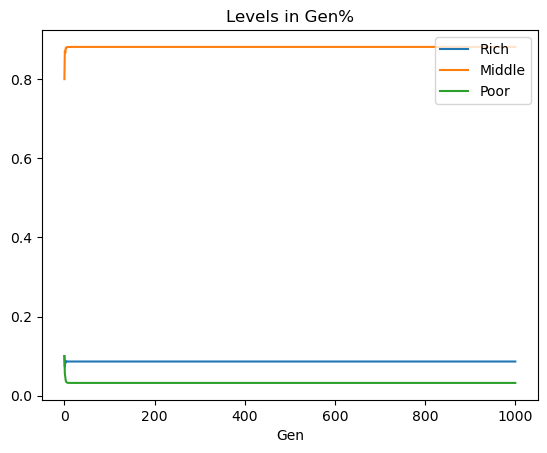

In [96]:
plt.plot(levels_rate[:, 0], label="Rich")
plt.plot(levels_rate[:, 1], label="Middle")
plt.plot(levels_rate[:, 2], label="Poor")
plt.title("Levels in Gen%")
plt.xlabel("Gen")
plt.legend(loc="upper right")


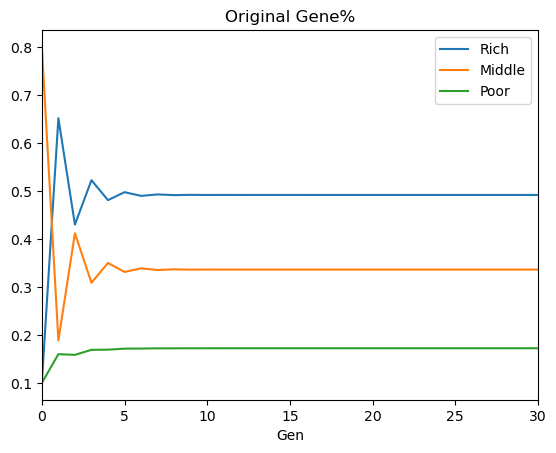

In [97]:
plt.plot(gene_keep_rate[:, 0], label="Rich")
plt.plot(gene_keep_rate[:, 1], label="Middle")
plt.plot(gene_keep_rate[:, 2], label="Poor")
plt.title("Original Gene%")
plt.xlabel("Gen")
plt.legend(loc="upper right")
plt.xlim(0, 30)
plt.show()


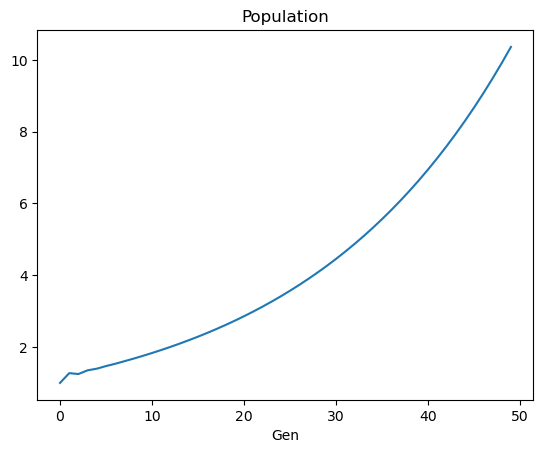

In [98]:
plt.plot(population_generations.sum(axis=1).sum(axis=1)[0:50], label="Rich")
plt.title("Population")
plt.xlabel("Gen")
plt.show()


## 结论

1. 尝试调整参数会发现，人口等级比例基本是保持稳定的，即便迭代了上百代都跟初始比例差不多；
2. 但是各参数对不同阶级最原始基因的保留是有巨大影响的（但是总体来看富人的基因保留更多，即便初始0.1发展到后面基本上收敛到50%，中等阶级和穷人合计50%）。